In [1]:
!pip install pandas scikit-learn matplotlib

In [2]:
import string
import re

import pandas as pd
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score,\
    f1_score, classification_report
from sklearn.model_selection import train_test_split

Файлы с данными должны лежать в папке hw4.

In [3]:
train_file = 'train.csv'
test_file = 'test.csv'

In [4]:
train_df = pd.read_csv(train_file, index_col='ID')

# Предобработка данных

In [5]:
train_df.sample(10, random_state=42)

,url,title,label
ID,,,
54589,www.kinotrast.com,Сериал Качели 2018 Беларусь Все серии смотреть...,0
41071,pc01.ru,Шкаф от спального гарнитура Энрике - 37 000 ру...,0
19161,forum.zoneofgames.ru,SWAT 3: Close Quarters Battle - Русификаторы -...,0
75429,librebook.me,"Читать онлайн электронную книгу Прометей, или ...",0
121091,meduniver.com,Как научить щедрости собственного мужчину и от...,0
35498,sutochno.ru,"2-комнатная квартира посуточно, Ашкелон, Ха-На...",0
51325,finalniiiepra.xyz,Заявка принята,0
82954,nabugre.com,Виза в Китай в Гонконге: получение для россиян...,0
87724,stavropol.hh.ru,"Вакансии компании Карт Бланш, ООО ПКФ",0


В данных есть повторы.

In [6]:
train_df.drop(index=np.nonzero(
    train_df.duplicated(subset=['url', 'title']))[0],
    inplace=True)

In [7]:
train_df.info()
train_df[train_df.isna().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
Index: 130511 entries, 0 to 135308
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     130511 non-null  object
 1   title   130510 non-null  object
 2   label   130511 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.0+ MB


,url,title,label
ID,,,
78497,jpg-1.com,NaN,0


Удалим строку с nan:

In [8]:
train_df.dropna(inplace=True)

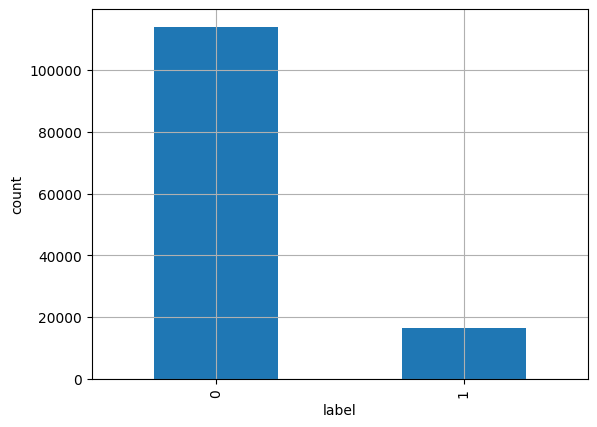

In [9]:
train_df['label'].value_counts().plot.bar()
plt.ylabel('count')
plt.grid()
plt.show()

Датасет несбалансирован.

In [10]:
url_alphabet = set()
for r in train_df['url']:
    url_alphabet.update(r)
print(sorted(list(url_alphabet)))

[' ', '%', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'O', 'R', 'S', 'U', 'V', 'W', 'Z', '\\', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'А', 'Б', 'Д', 'Е', 'Ж', 'З', 'И', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'Ь', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ы', 'ь', 'э', 'ю', 'я']


В url есть русские буквы и спец. символы, не свойственные url.

In [11]:
for r in train_df['url']:
    if ',' in r:
        print(r)

D:\Мои документы\ПОЖАРНАЯ БЕЗОПАСТНОСТЬ\Деревообрабатывающий цех 2017 г. Инструкции о мерах пожарной безопасности, противопожарные инструктажи, приказы..mht


Эм... Ну, окей.

In [12]:
black_list = ' ,:@'
for url in train_df['url']:
    for c in black_list:
        if c in url:
            print(url)
            break

golosua.com:8080
www.pornktube.porn:443
cid:op.mhtml.1381394256635.7529b63640301a1c@10.27.184.97
file:
mirkmf.ru:443
www.kzn.ru:443
192.168.0.3:33333
graciasport.ru:443
gorcentr:7Ad6xZ@gorcentr.i58.ru
F:
C:
C:\Users\nzarubin\AppData\Local\Microsoft\Windows\INetCache\Content.Outlook\ES2N2VVV\shtornyj-polupricep-2013-g-v-saf-koroba-71959610.html
bemob.online:443
www.kzn.ru:443
www.kzn.ru:443
graciasport.ru:443
permnews.ru:443
rubilnik.ru:443
antitube.ru:443
localhost:7784
ivnoski.ru:443
permnews.ru:443
file:
rubilnik.ru:443
opt-hoz.ru:443
www0.kommersant.ru:8080
hosex.net:443
glavnoe.ua:443
D:\Мои документы\ПОЖАРНАЯ БЕЗОПАСТНОСТЬ\Деревообрабатывающий цех 2017 г. Инструкции о мерах пожарной безопасности, противопожарные инструктажи, приказы..mht
C:
rubilnik.ru:443
opt-hoz.ru:443
C:\Users\Sergey\Desktop\5.htm
C:
newtonew.com:81
mc.ru:8080
porn-video.ru:443
file:
ivnoski.ru:443


Есть различные локальные страницы ('C:', 'D:', '192.168.*', ...). Не будем их удалять, потому что на это нужно потратить много времени, а выхлоп небольшой.

In [13]:
s = set()
for title in train_df['title']:
    s.update(title)
print(len(s))
print(sorted(list(s)))

3165
['\x04', '\x0b', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x96', '\x97', '\xa0', '¡', '£', '¤', '¦', '§', '©', '«', '¬', '\xad', '®', '°', '±', '²', '³', '´', 'µ', '·', '¹', 'º', '»', '¼', '½', '¿', 'À', 'Á', 'Â', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ë', 'Ì', 'Í', 'Î', 'Ð', 'Ñ', 'Ó', 'Ö', '×', 'Ø', 'Ú', 'Ü', 'Ý', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'Ā', 'ā', 'Ă', 'ă', 'ą', 'ć', 'Ċ', 'Č', 'č', 'Đ', 'đ', 'ē', 'ĕ', 'ė', 'ę', 'ě', 'Ğ', 'ğ', 'ģ', 

Сделаем фильтр символов, чтобы сократить словарь. Оставим только буквы русского и английского языков, цифры и различные "клавиатурный" спец. символы.

In [14]:
russian_letters = ''.join([chr(i) for i in range(ord('а'), ord('я') + 1)])
russian_letters = russian_letters + russian_letters.upper() + 'ёЁ'
title_white_list = set(string.printable + russian_letters)


# Будем заменять остальные символы на пробелы, чтобы не склеивать слова
def map_title(s: str, replace_sym: str = ' '):
    res = ''.join([c if c in title_white_list else replace_sym for c in s])
    # заменяем ё на е
    res = res.replace('ё', 'е')
    res = res.replace('Ё', 'Е')
    # Заменяем двойные (и более) пробелы на обычные
    res = re.sub(' +', ' ', res)
    return res

# Разбиение на train и val

In [15]:
X = train_df.drop(columns=['label'])
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.8, random_state=42
    )
X_train['title'] = X_train['title'].apply(map_title)
X_val['title'] = X_val['title'].apply(map_title)

# Построение модели

In [16]:
vectorizer_title = TfidfVectorizer(
    stop_words='english', max_features=20000, ngram_range=(1, 4)
    )
vectorizer_url = TfidfVectorizer(
    max_features=2000, analyzer='char', ngram_range=(1, 5)
    )

X_train_vec_title = vectorizer_title.fit_transform(X_train['title'])
X_train_vec_url = vectorizer_url.fit_transform(X_train['url'])
X_train_vec = sparse.hstack((X_train_vec_url, X_train_vec_title))

classifier = SGDClassifier()
classifier.fit(X_train_vec, y_train)

SGDClassifier()

In [17]:
base_models = {
    'vectorizer_title': vectorizer_title,
    'vectorizer_url': vectorizer_url,
    'classifier': classifier
    }


def predict_model(data: pd.DataFrame, models: dict = base_models):
    X_vec_title = models['vectorizer_title'].transform(
        data['title'].apply(map_title)
        )
    X_vec_url = models['vectorizer_url'].transform(data['url'])
    X_vec = sparse.hstack((X_vec_url, X_vec_title))
    y_pred = models['classifier'].predict(X_vec)
    return y_pred

In [18]:
y_train_pred = predict_model(X_train)
y_val_pred = predict_model(X_val)

In [19]:
print('Train:')
print('Precision:', precision_score(y_train, y_train_pred))
print('Recall:', recall_score(y_train, y_train_pred))
print('F1:', f1_score(y_train, y_train_pred))
print()
print('Validation:')
print('Precision:', precision_score(y_val, y_val_pred))
print('Recall:', recall_score(y_val, y_val_pred))
print('F1:', f1_score(y_val, y_val_pred))

Train:
Precision: 0.9973427812223207
Recall: 0.9415431394906879
F1: 0.9686400250254165

Validation:
Precision: 0.9955242966751918
Recall: 0.9345738295318127
F1: 0.9640866873065016


In [20]:
print('Train:')
print(classification_report(y_train, y_train_pred))
print('Validation:')
print(classification_report(y_val, y_val_pred))

Train:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     91253
           1       1.00      0.94      0.97     13155

    accuracy                           0.99    104408
   macro avg       0.99      0.97      0.98    104408
weighted avg       0.99      0.99      0.99    104408

Validation:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     22770
           1       1.00      0.93      0.96      3332

    accuracy                           0.99     26102
   macro avg       0.99      0.97      0.98     26102
weighted avg       0.99      0.99      0.99     26102



## Немного аналитики модели

Найдем топ токенов, которые наиболее сильно характеризуют класс по мнению модели.

In [21]:
def get_top_k(coef: np.ndarray, vectorizer: TfidfVectorizer, k: int = 10):
    i = np.argsort(coef)
    vocabulary = vectorizer.get_feature_names_out()
    return vocabulary[i[:k]], vocabulary[i[-k:][::-1]]

In [22]:
top_url = get_top_k(classifier.coef_[0, :2000], vectorizer_url)
pd.DataFrame({'label=0': top_url[0], 'label=1': top_url[1]})

,label=0,label=1
0,ser,sex
1,.,porn
2,.ru,ero
3,.r,orn
4,ru,por
5,rut,xx
6,ox,x
7,exp,rn
8,utu,xxx
9,lp,porno


In [23]:
top_title = get_top_k(classifier.coef_[0, 2000:], vectorizer_title)
pd.DataFrame({'label=0': top_title[0], 'label=1': top_title[1]})

,label=0,label=1
0,купить,порно
1,как,porn
2,скачать,sex
3,смотреть онлайн,xxx
4,хорошем,porno
5,mp3,videos
6,новости,эротика
7,форум,секс
8,video mail,xvideos
9,video mail ru,video


# Создаем submission

In [24]:
submission_file = 'submission prefinal.csv'

test_df = pd.read_csv(test_file, index_col='ID')
y_test_pred = predict_model(test_df)

res = pd.DataFrame(y_test_pred, index=test_df.index, columns=['label'])
res.to_csv(submission_file)

Результат: 0.96311